## Setup

Installiere zunächst die erforderlichen Bibliotheken:

In [14]:
%pip install ultralytics roboflow opencv-python
%pip install supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 68.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 44.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 37.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 99.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 108.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB

## Dataset vorbereiten und laden

Aus Robloflow wird ein Datensatz genommen, vorbereitet und geladen für das Modelltraining.

In [6]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="R9VyjDodYg9dCZe6zld4")
project = rf.workspace("mywork747").project("billboard-tkbqe")
version = project.version(2)
dataset = version.download("yolov12")
                

Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Billboard-2 in yolov12:: 100%|██████████| 297/297 [00:11<00:00, 25.41it/s]


## Dataset prüfen und Samples inkl. Annotationen anzeigen

In diesem Kapitel geht es darum, sicherzustellen, dass das Dataset korrekt geladen und die Annotationen (z.B. Bounding Boxes) für die Objekterkennung im Bild vorhanden und korrekt formatiert sind. Dies ist ein wichtiger Schritt vor dem Training eines Modells, da es sicherstellt, dass die Daten in der richtigen Form vorliegen, um das Modell effektiv zu trainieren.

Mit folgendem Code kann der Pfad abgefragt werden und für den weiteren Code verwendet werden:

In [7]:
import os
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared


Anzahl der Bilder: 20
Anzahl der Label-Dateien: 20

Annotationen für 13123_jpg.rf.bb96fcc67221fee1db2108f1adcf138a.jpg:
0 0.652614875 0.49 0.6551141995192308 0.2116666658653846 0.38185474759615384 0.19833333413461537 0.3810216394230769 0.4883333341346154 0.652614875 0.49
Überspringe ungültige Annotation (nicht 5 Werte): 0 0.652614875 0.49 0.6551141995192308 0.2116666658653846 0.38185474759615384 0.19833333413461537 0.3810216394230769 0.4883333341346154 0.652614875 0.49


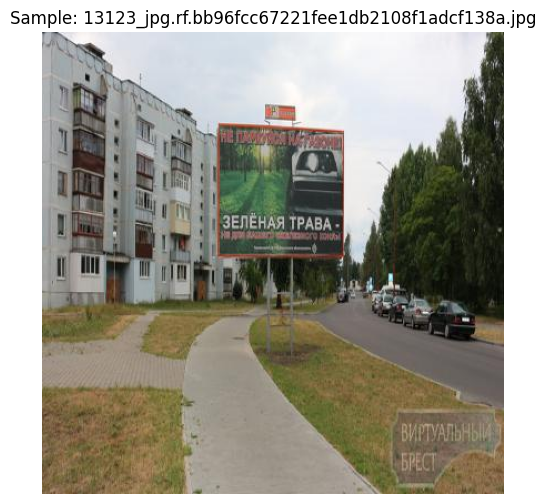


Annotationen für 2_billboard_jpg.rf.50730d163b29c3fd1c53e916ab403083.jpg:
0 0.8422113076923077 0.7499631658653846 0.8422113076923077 0.12081921394230768 0.2051934543269231 0.08840430288461538 0.20444214903846153 0.08840430288461538 0.2002358942307692 0.7484897596153846 0.8422113076923077 0.7499631658653846
Überspringe ungültige Annotation (nicht 5 Werte): 0 0.8422113076923077 0.7499631658653846 0.8422113076923077 0.12081921394230768 0.2051934543269231 0.08840430288461538 0.20444214903846153 0.08840430288461538 0.2002358942307692 0.7484897596153846 0.8422113076923077 0.7499631658653846


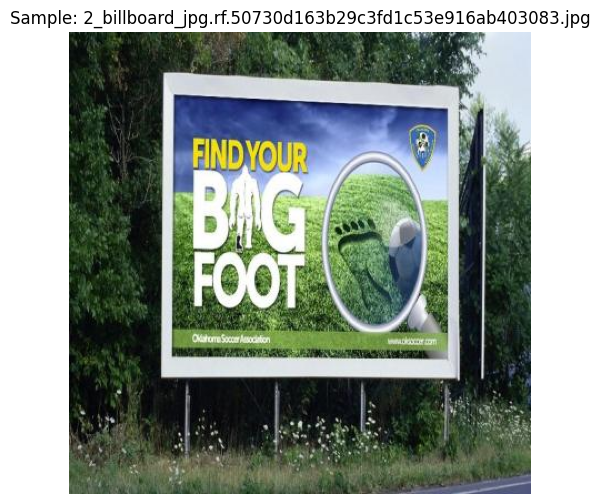


Annotationen für images-16_jpeg.rf.33aff7a1bff4060eda0dae9eb7b2a069.jpg:
0 0.8204010072115384 0.5110336826923076 0.8158347788461539 0.2103497235576923 0.38386947355769235 0.20260678846153846 0.3811299831730769 0.5071622139423076 0.8204010072115384 0.5110336826923076
Überspringe ungültige Annotation (nicht 5 Werte): 0 0.8204010072115384 0.5110336826923076 0.8158347788461539 0.2103497235576923 0.38386947355769235 0.20260678846153846 0.3811299831730769 0.5071622139423076 0.8204010072115384 0.5110336826923076


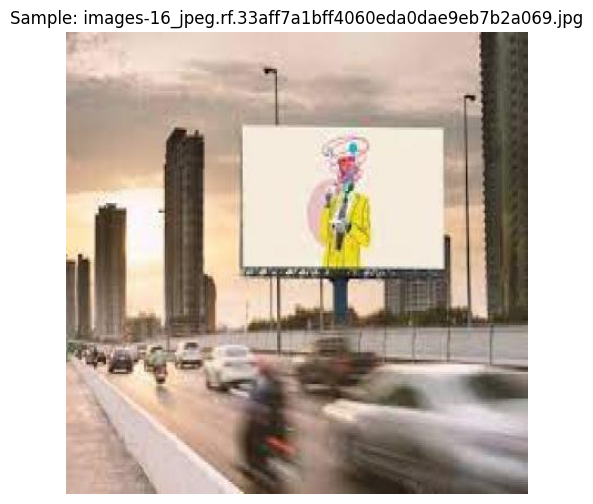

In [8]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from pathlib import Path

# Verzeichnis mit den Trainingsdaten
image_folder = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/valid/images'  # Pfad zu den Bildern
label_folder = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/valid/labels'  # Pfad zu den Annotationsdateien

# Überprüfe, ob Bilder und Labels existieren
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]  # oder '.png'
label_files = [f for f in os.listdir(label_folder) if f.endswith('.txt')]

print(f"Anzahl der Bilder: {len(image_files)}")
print(f"Anzahl der Label-Dateien: {len(label_files)}")

# Zeige 3 zufällige Samples mit Annotationen
for _ in range(3):  # Zeige 3 zufällige Samples
    # Wähle ein zufälliges Bild
    image_file = random.choice(image_files)
    image_path = os.path.join(image_folder, image_file)

    # Lade das Bild
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konvertiere von BGR zu RGB für Matplotlib

    # Lade die zugehörige Annotationsdatei (YOLO-Format)
    label_file = image_file.replace('.jpg', '.txt')  # gleiche Namenskonvention wie bei den Bildern
    label_path = os.path.join(label_folder, label_file)

    # Überprüfe, ob die Label-Datei existiert
    if os.path.exists(label_path):
        # Lade die Annotationen
        with open(label_path, 'r') as f:
            annotations = f.readlines()

        # Ausgabe der Annotationen
        print(f"\nAnnotationen für {image_file}:")
        for annotation in annotations:
            print(annotation.strip())  # .strip() entfernt führende und nachfolgende Leerzeichen/Zeilenumbrüche

        # Zeichne die Bounding Boxes auf das Bild
        for annotation in annotations:
            # Entferne Leerzeichen und überprüfe, ob die Annotation genau 5 Werte enthält
            annotation = annotation.strip()  # Entfernt führende/trailing Leerzeichen und Zeilenumbrüche

            # Überspringe leere Zeilen oder Zeilen mit falscher Anzahl an Werten
            if not annotation:  # Leere Zeilen überspringen
                continue
            annotation_values = annotation.split()

            # Überprüfe, ob die Annotation genau 5 Werte hat
            if len(annotation_values) == 5:
                # YOLO-Format: class_id x_center y_center width height (normalisierte Werte)
                class_id, x_center, y_center, width, height = map(float, annotation_values)

                # Bilddimensionen
                img_height, img_width, _ = img.shape

                # Berechne die Bounding Box-Koordinaten (Pixelwerte)
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                x_max = int((x_center + width / 2) * img_width)
                y_max = int((y_center + height / 2) * img_height)

                # Zeichne die Bounding Box auf das Bild
                cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blau für Bounding Box
                # Füge das Label hinzu
                cv2.putText(img_rgb, str(int(class_id)), (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            else:
                # Ausgabe der fehlerhaften Annotationen
                print(f"Überspringe ungültige Annotation (nicht 5 Werte): {annotation}")

    # Zeige das Bild mit Annotationen an
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')  # Achsen ausblenden
    plt.title(f"Sample: {image_file}")
    plt.show()


## Modell trainieren

Nutze den nachfolgenden Code, um das Modell zu trainieren:

In [1]:
from ultralytics import YOLO

# Modell laden
model = YOLO('yolo11s-seg.pt')  # Wähle je nach Bedarf yolov12n, yolov12s, yolov12m, yolov12l oder yolov12x

# Training starten
results = model.train(
    data='/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/data.yaml',  # Pfad zur YAML-Datei deines Datensatzes
    epochs=10,
    imgsz=640,
    batch=2,
    device='cpu'  # Setze auf 'cpu' oder 'cuda' je nach Verfügbarkeit
)

Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimize

2025-05-15 12:10:44,580	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-15 12:10:45,011	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
train: Scanning /mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/train/labels.cache... 124 images, 4 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<?, ?it/s]/anaconda/envs/jupyter_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/valid/labels.cache... 20 images, 0 back

## Vorhersagen durchführen

Nach dem Training kannst du Vorhersagen auf Bildern aus deinem Validierungsdatensatz durchführen:


0: 640x640 1 Billboards, 386.8ms
Speed: 3.2ms preprocess, 386.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


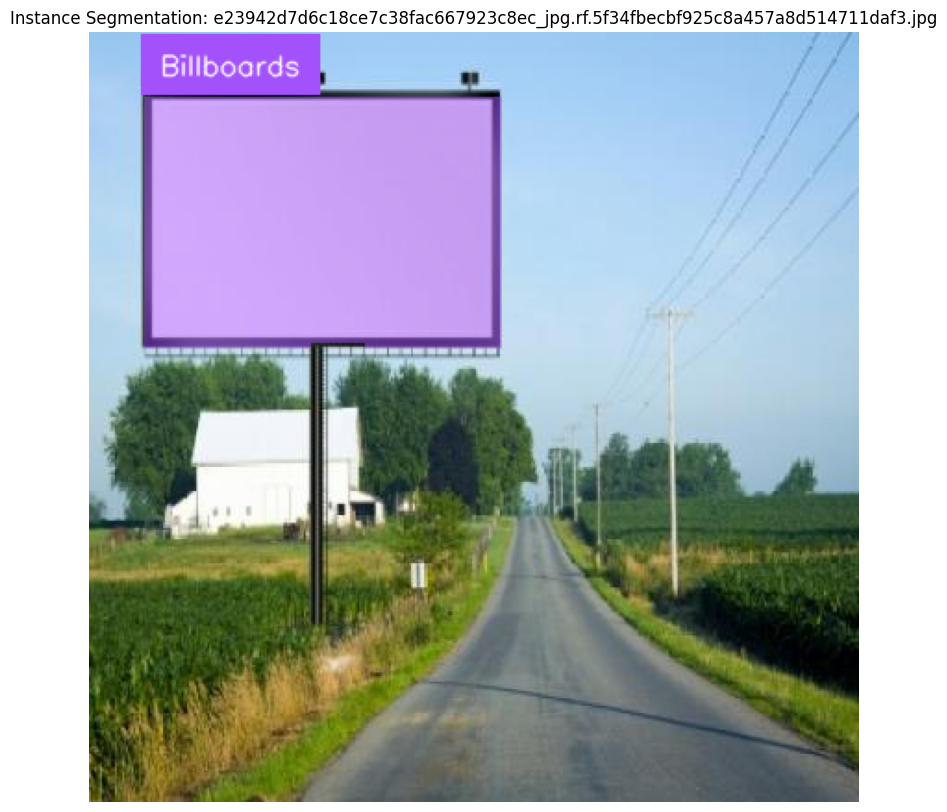

In [16]:
import random
import cv2
import matplotlib.pyplot as plt
from supervision import Detections, MaskAnnotator, LabelAnnotator
from ultralytics import YOLO
from pathlib import Path

# Modell laden (Segmentierungsmodell!)
model = YOLO('/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/runs/segment/train3/weights/best.pt')

# Pfad zum Validierungs-Datensatz
dataset_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Billboard-2/valid/images'
image_paths = list(Path(dataset_path).glob('*.jpg'))  # ggf. '*.png' je nach Format

# Zufälliges Bild auswählen und laden
image_path = random.choice(image_paths)
image = cv2.imread(str(image_path))

# Vorhersage durchführen
results = model(image)[0]

# Detections aus den Ergebnissen extrahieren (inkl. Masken)
detections = Detections.from_ultralytics(results).with_nms()

# Annotatoren für Masken und Labels
mask_annotator = MaskAnnotator()
label_annotator = LabelAnnotator()

# Annotieren
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# Ergebnis anzeigen
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Instance Segmentation: {image_path.name}")
plt.show()


## Modell evaluieren

Um die Leistung deines Modells zu bewerten, kannst du Metriken wie F1-Score, Recall und Precision usw. verwenden:

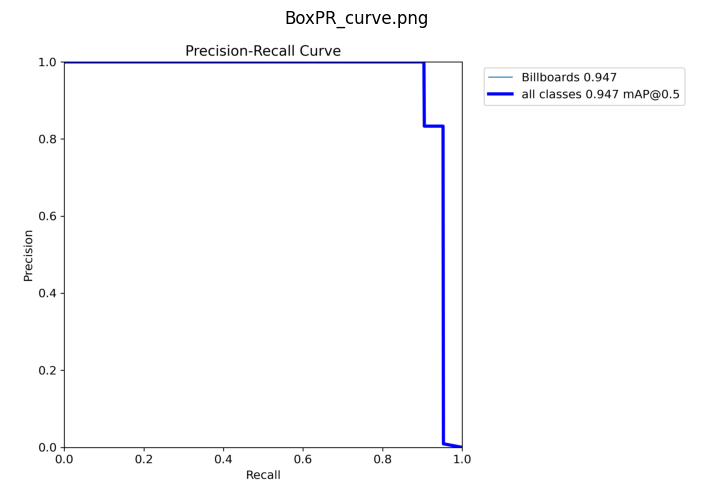

<Figure size 640x480 with 0 Axes>

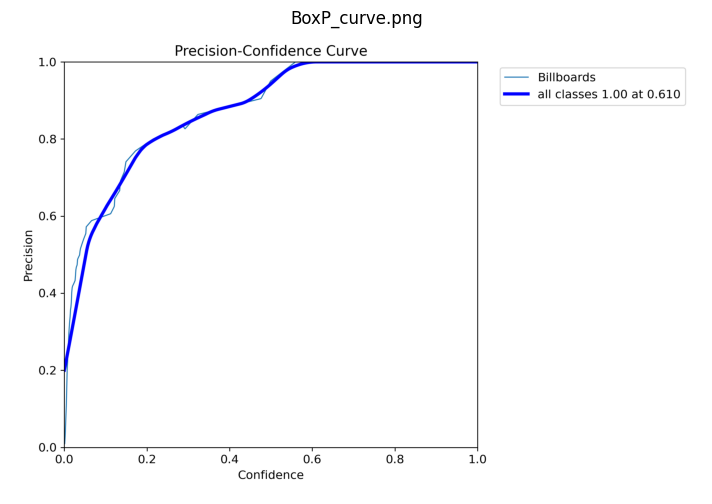

<Figure size 640x480 with 0 Axes>

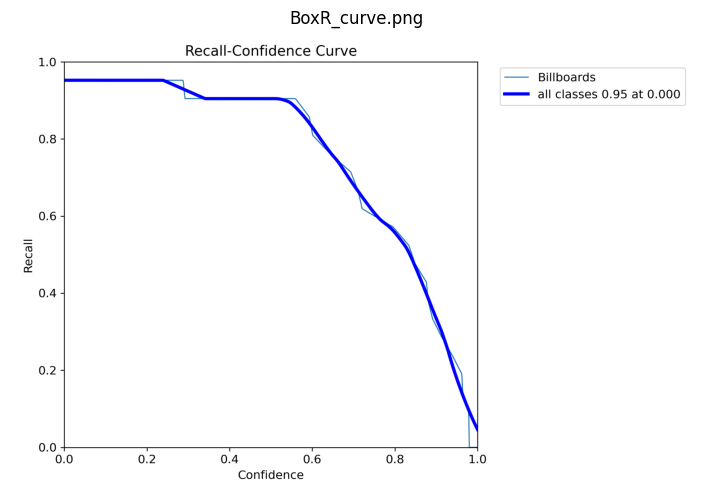

<Figure size 640x480 with 0 Axes>

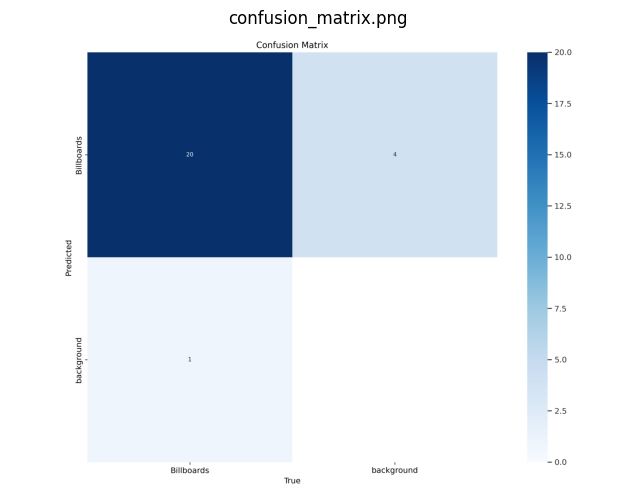

<Figure size 640x480 with 0 Axes>

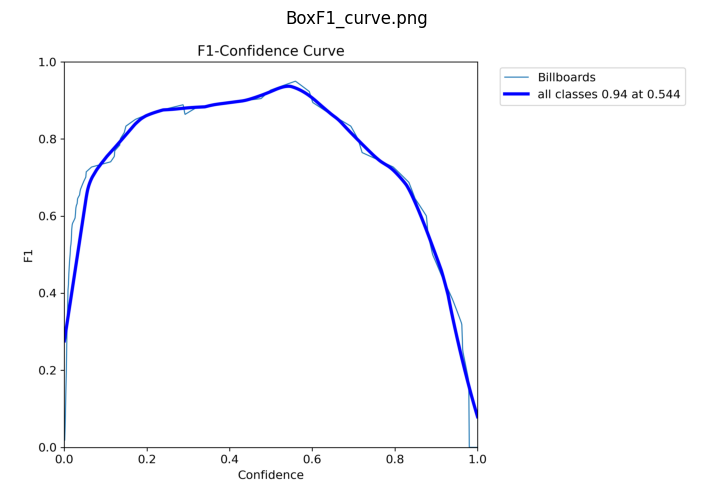

<Figure size 640x480 with 0 Axes>

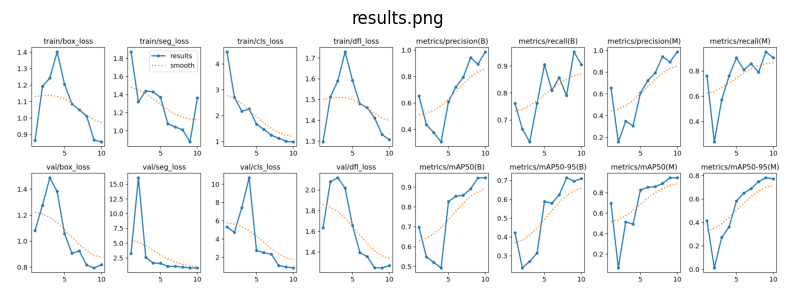

<Figure size 640x480 with 0 Axes>

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Verzeichnis mit den PNG-Bildern
image_folder = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/runs/segment/train3'

# Liste der Bilddateien
image_files = [
    "BoxPR_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "confusion_matrix.png",
    "BoxF1_curve.png",
    "results.png"
]

# Zeige jedes Bild mit Abstand
for image_file in image_files:
    # Bild laden
    img_path = os.path.join(image_folder, image_file)
    img = mpimg.imread(img_path)

    # Erstelle eine neue Figur mit plt.subplots() und füge das Bild hinzu
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.axis('off')  # Achsen ausblenden
    ax.set_title(image_file)  # Bildname als Titel
    plt.show()  # Bild anzeigen

    # Abstand hinzufügen zwischen den Bildern
    plt.subplots_adjust(hspace=0.5)  # hspace fügt vertikalen Abstand hinzu


### Precision Curve

**Definition**:  
Die **Precision Curve** zeigt, wie sich die Precision eines Klassifikators in Abhängigkeit von der Konfidenz des Modells verändert. Der Schwellenwert des Modells beeinflusst, wie sicher das Modell sein muss, um eine positive Klassifikation zu treffen.  

**Precision**:  
Precision ist der Anteil der korrekt identifizierten positiven Vorhersagen an allen Vorhersagen, die als positiv klassifiziert wurden.  

**Interpretation**:  
Ein hoher Wert auf der Precision-Kurve bedeutet, dass das Modell eine hohe Präzision bei seinen positiven Vorhersagen hat und nur wenige falsch-positive Vorhersagen macht.

<br>
<br>


### Recall Curve

**Definition**:  
Die **Recall Curve** zeigt, wie sich der Recall eines Klassifikators bei verschiedenen Schwellenwerten verändert. Recall misst den Anteil der tatsächlichen positiven Instanzen, die korrekt vom Modell erkannt wurden.  

**Recall**:  
Recall ist der Anteil der positiven Instanzen, die das Modell korrekt identifiziert hat, aus allen tatsächlich positiven Instanzen.  

**Interpretation**:  
Ein hoher Wert auf der Recall-Kurve bedeutet, dass das Modell viele der tatsächlichen positiven Instanzen korrekt identifiziert, jedoch könnte auch eine höhere Anzahl an falsch-positiven Vorhersagen produziert werden.

<br>
<br>

### Confusion Matrix (Verwirrungsmatrix)

**Definition**:  
Die **Confusion Matrix** zeigt die Leistung eines Klassifikators und gibt an, wie oft jede Klasse korrekt oder falsch klassifiziert wurde.  

**Werte der Matrix**:  
- **True Positives (TP)**: Richtig positiv klassifizierte Instanzen.  
- **False Positives (FP)**: Fälschlicherweise als positiv klassifizierte Instanzen.  
- **True Negatives (TN)**: Richtig negativ klassifizierte Instanzen.  
- **False Negatives (FN)**: Fälschlicherweise als negativ klassifizierte Instanzen.  

**Interpretation**:  
Eine gute Confusion Matrix zeigt hohe Werte in den Zellen für True Positives und True Negatives, was bedeutet, dass das Modell viele Instanzen korrekt klassifiziert hat.

<br>
<br>


### F1 Score Curve

**Definition**:  
Der **F1-Score** ist das harmonische Mittel von Precision und Recall und hilft dabei, ein ausgewogenes Maß für die Leistung eines Modells zu berechnen.  

**F1-Score**:  
Der F1-Score kombiniert die Precision und den Recall eines Modells und ist besonders nützlich, wenn eine Balance zwischen diesen beiden Metriken gewünscht wird.  

**Interpretation**:  
Ein hoher F1-Score bedeutet, dass das Modell sowohl eine hohe Präzision als auch einen hohen Recall aufweist. Dies zeigt, dass das Modell keine großen Kompromisse bei einer der beiden Metriken eingeht.

<br>
<br>

### Precision-Recall Curve (PR Curve)

**Definition**:  
Die **Precision-Recall Curve** zeigt das Verhältnis zwischen Precision (Präzision) und Recall (Sensitivität) des Klassifikators bei verschiedenen Schwellenwerten.  

**Precision**:  
Precision ist der Anteil der korrekt identifizierten positiven Vorhersagen an allen Vorhersagen, die das Modell als positiv klassifiziert hat.  

**Recall**:  
Recall ist der Anteil der tatsächlich positiven Instanzen, die korrekt vom Modell erkannt wurden.  

**Interpretation**:  
Eine gute PR-Kurve zeigt, dass das Modell sowohl eine hohe Precision als auch einen hohen Recall erreicht. Wenn der Bereich unter der Kurve groß ist, bedeutet das ein gutes Modell.

<br>
<br>

### Mean Average Precision (mAP)

Bei Instance Segmentation bewertet mAP gleichzeitig zwei Dinge:

1. Ob das Modell das richtige Objekt erkennt (Klassifikation)

1. Ob die vorhergesagte Maske (Form und Position) dem Ground Truth nahekommt (Segmentierungsgenauigkeit)

Das geschieht über die Berechnung von:

- IoU (Intersection over Union) zwischen der vorhergesagten Maske und der tatsächlichen Maske

- Precision & Recall bei verschiedenen IoU-Schwellen (z. B. 0.5, 0.75)

Dann wird daraus Average Precision (AP) pro Klasse berechnet – und über alle Klassen gemittelt ergibt sich mAP

| mAP-Wert        | Bedeutung (grob)                                                                             |
| --------------- | -------------------------------------------------------------------------------------------- |
| **> 0.80**      | Exzellente Segmentierung & Erkennung                                                         |
| **0.60 – 0.80** | Gutes Modell, ggf. noch Optimierungspotenzial                                                |
| **< 0.60**      | Mäßige bis schlechte Leistung → Datensatz prüfen, Architektur oder Hyperparameter verbessern |

<br>
<br>

#### Intersection over Union (IoU): 

Misst die räumliche Überlappung zwischen einer vorhergesagten Bounding Box und einer Ground Truth Bounding Box. Während IoU die Lokalisierungsqualität für einzelne Erkennungen bewertet, verwendet mAP IoU-Schwellenwerte (z. B. 0,5 oder die Spanne 0,5:0,95), um zu bestimmen, ob eine Erkennung als "true positive" gilt, und fasst dann die Leistung über Klassen und Konfidenzstufen hinweg zusammen. IoU selbst ist eine Komponente der mAP-Berechnung und kein Ersatz dafür.


## Hyperparameter-Tuning

Für eine feinere Anpassung deines Modells kannst du Hyperparameter wie Lernrate, Anzahl der Epochen und Batch-Grösse und sehr viele weitere Parameter anpassen. Nachfolgend wird in der Tabelle angezeigt welche Möglichkeiten für das Hyperparamter-Tuning bestehen sowie ein Beispielcode:

| Argument   | Typ            | Standard | Beschreibung |
|------------|----------------|----------|--------------|
| `model`    | `str`          | `None`   | Gibt die Modelldatei für das Training an. Akzeptiert einen Pfad zu entweder einer `.pt` vortrainiertes Modell oder eine `.yaml` Konfigurationsdatei. Unerlässlich für die Definition der Modellstruktur oder die Initialisierung von Gewichten. |
| `data`     | `str`          | `None`   | Pfad zur Konfigurationsdatei des Datensatzes (z. B. `coco8.yaml`). Enthält Pfade zu Trainings- und Validierungsdaten, Klassennamen und Anzahl der Klassen. |
| `epochs`   | `int`          | `100`    | Gesamtzahl der Trainingsepochen. Jede Epoche stellt einen vollständigen Durchlauf durch den Datensatz dar. Anpassung dieses Wertes beeinflusst Dauer und Leistung. |
| `time`     | `float`        | `None`   | Maximale Trainingszeit in Stunden. Überschreibt `epochs`-Wert. Automatischer Abbruch nach angegebener Dauer, z. B. bei begrenzten Ressourcen. |
| `patience` | `int`          | `100`    | Anzahl Epochen ohne Validierungsverbesserung, bevor das Training gestoppt wird. Verhindert Überanpassung. |
| `batch`    | `int`          | `16`     | Batch-Größe. Drei Modi: fester Wert (z. B. `16`), `-1` für automatische GPU-Auslastung oder z. B. `0.70` für 70 %-Nutzung. |
| `imgsz`    | `int or list`  | `640`    | Zielbildgröße, auf die alle Trainingsbilder skaliert werden. Beeinflusst Genauigkeit und Rechenaufwand. |
| `save`     | `bool`         | `True`   | Speichert Kontrollpunkte und finale Gewichte. Nützlich für Wiederaufnahme und Deployment. |
| `save_period` | `int`       | `-1`     | Speichert Modell alle `n` Epochen. `-1` deaktiviert periodisches Speichern. |
| `cache`    | `bool`         | `False`  | Zwischenspeicherung von Bildern im RAM (`True`), auf Disk (`'disk'`) oder deaktiviert (`False`). Beschleunigt Training, benötigt aber Speicher. |
| `device`       | `int / str / list` | `None`   | Gibt das Rechengerät an: einzelne GPU (`0`), mehrere GPUs (`[0,1]`), CPU (`'cpu'`), Apple MPS (`'mps'`) oder automatisch (`-1`/`[-1,-1]`). |
| `workers`      | `int`              | `8`      | Anzahl der Threads für Datenladen pro Prozess. Erhöht Datenvorverarbeitungsgeschwindigkeit. |
| `project`      | `str`              | `None`   | Name des Projektverzeichnisses für Trainingsergebnisse. |
| `name`         | `str`              | `None`   | Name des Trainingslaufs. Erstellt Unterverzeichnis im Projektordner. |
| `exist_ok`     | `bool`             | `False`  | Überschreibt bestehende Projektnamenverzeichnisse, wenn `True`. |
| `pretrained`   | `bool or str`      | `True`   | Startet mit vortrainiertem Modell (`True`) oder spezifischem Pfad (`str`). |
| `optimizer`    | `str`              | `'auto'` | Optimierungsalgorithmus: `SGD`, `Adam`, `AdamW`, etc. oder `auto` für automatische Auswahl. |
| `seed`         | `int`              | `0`      | Zufalls-Seed für reproduzierbare Ergebnisse. |
| `deterministic`| `bool`             | `True`   | Erzwingt deterministisches Verhalten. Reduziert Varianz, evtl. langsamer. |
| `single_cls`   | `bool`             | `False`  | Behandelt alle Klassen als eine. Für binäre Klassifikation nützlich. |
| `classes`      | `list[int]`        | `None`   | Liste von Klassen-IDs, auf die trainiert werden soll. |
| `rect`         | `bool`             | `False`  | Rechteckiges Training zur Minimierung von Padding. |
| `multi_scale`  | `bool`             | `False`  | Ändert `imgsz` beim Training dynamisch. Fördert Modellrobustheit. |
| `cos_lr`       | `bool`             | `False`  | Nutzt Cosine-LR-Scheduler zur Lernratenanpassung über die Zeit. |
| `close_mosaic` | `int`              | `10`     | Deaktiviert Mosaic-Augmentation in den letzten `N` Epochen. Stabilisiert das Training. |
| `resume`       | `bool`             | `False`  | Nimmt Training aus letztem Checkpoint wieder auf. |
| `amp`          | `bool`             | `True`   | Aktiviert automatisches Mixed-Precision-Training für Effizienz. |
| `fraction`     | `float`            | `1.0`    | Prozentualer Anteil des Datensatzes, der verwendet wird. |
| `profile`      | `bool`             | `False`  | Erstellt ONNX- und TensorRT-Profile zur Laufzeit. |
| `freeze`       | `int or list`      | `None`   | Friert erste `n` Schichten oder Schichten per Index ein. Für Transfer Learning nützlich. |
| `lr0`            | `float`        | `0.01`   | Anfangslernrate (z. B. `1E-2` für SGD, `1E-3` für Adam). Kritisch für Lernverhalten. |
| `lrf`            | `float`        | `0.01`   | Endlernrate als Bruchteil von `lr0` (z. B. `lr0 * lrf`). |
| `momentum`       | `float`        | `0.937`  | Momentum für SGD bzw. `beta1` für Adam. Steuert Gradientenverlauf. |
| `weight_decay`   | `float`        | `0.0005` | L2-Regularisierung. Verhindert Überanpassung durch Bestrafung großer Gewichte. |
| `warmup_epochs`  | `float`        | `3.0`    | Anzahl Aufwärm-Epochen für die Lernrate. |
| `warmup_momentum`| `float`        | `0.8`    | Anfangs-Momentum in der Aufwärmphase. Passt sich schrittweise an. |
| `warmup_bias_lr` | `float`        | `0.1`    | Lernrate für Bias-Parameter während Aufwärmphase. |
| `box`            | `float`        | `7.5`    | Gewichtung des Box-Verlusts bei der Gesamtverlustberechnung. |
| `cls`            | `float`        | `0.5`    | Gewichtung des Klassifizierungsverlusts. |
| `dfl`            | `float`        | `1.5`    | Gewichtung des Distribution Focal Loss (DFL). |
| `pose`           | `float`        | `12.0`   | Gewichtung des Pose-Verlusts (für Keypoints). |
| `kobj`           | `float`        | `2.0`    | Gewichtung des Objektivitätsverlusts bei Keypoints. |
| `nbs`            | `int`          | `64`     | Nominale Batchgröße zur Normalisierung des Verlusts. |
| `overlap_mask`   | `bool`         | `True`   | Bestimmt, ob sich Masken überlappen dürfen. |
| `mask_ratio`     | `int`          | `4`      | Downsample-Verhältnis bei Segmentierungsmasken. |
| `dropout`        | `float`        | `0.0`    | Dropout-Rate zur Regularisierung bei Klassifikation. |
| `val`            | `bool`         | `True`   | Aktiviert Validierung während des Trainings. |
| `plots`          | `bool`         | `False`  | Erstellt Trainingsdiagramme und Vorhersagebeispiele. |


In [ ]:
results = model.train(
    data='/content/advertising-banner-finder-3/data.yaml',
    epochs=500,
    imgsz=640,
    batch=32,
    lr0=0.01,  # Lernrate
    lrf=0.01,  # Lernraten-Faktor
    momentum=0.937,
    weight_decay=0.0005,
    device='cpu'
)

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/advertising-banner-finder-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/train4/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /content/advertising-banner-finder-3/train/labels.cache... 36 images, 1 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1242.0±309.5 MB/s, size: 61.8 KB)



val: Scanning /content/advertising-banner-finder-3/valid/labels.cache... 10 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 11. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 